# Sentiment Data Exploration

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Test set

In [43]:
# Check test set classifications
test = pd.read_csv('../../data/classified-data/aspect_based_analysis.csv')

# The final test set is based on the subset of the aspect-based analysis raw data
# given by this mask.
mask = ((test['GPT Sentiment'] == test['Manual Sentiment']) & 
        (test['GPT Sentiment'] == test['FinBERT Sentiment']))

test[mask].info()
test[mask].describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6231 entries, 2 to 10751
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Headlines          6231 non-null   object
 1   Manual Sentiment   6231 non-null   object
 2   Topic              6231 non-null   object
 3   GPT Sentiment      6231 non-null   object
 4   FinBERT Sentiment  6231 non-null   object
dtypes: object(5)
memory usage: 292.1+ KB


,Headlines,Manual Sentiment,Topic,GPT Sentiment,FinBERT Sentiment
count,6231,6231,6231,6231,6231
unique,6204,3,4,3,3
top,Pulses prices end steady in tight movements,Positive,Company,Positive,Positive
freq,2,2247,3055,2247,2247


In [44]:
print(f'{(mask).sum() / len(test):.2%} of headlines kept\n')
print(test[mask].tail(10)[['Headlines', 'Manual Sentiment']])

57.95% of headlines kept

                                            Headlines Manual Sentiment
10739        Wipro, Siemens to exit Nifty from Monday          Neutral
10740               Dollar, euro surge in Asian trade         Positive
10744    Coriander, turmeric weaken on subdued demand         Negative
10745         European shares dip early; Wincor sinks         Negative
10746          Gram, masoor decline on subdued demand         Negative
10747         Jeera, pepper decline on subdued demand         Negative
10748    Negative on Chambal, Advanta: Mitesh Thacker         Negative
10749  Small, Mid-cap stocks may emerge outperformers         Positive
10750                   Rupee slips against US dollar         Negative
10751                    Rupee weak against US dollar         Negative


In [34]:
# Class distribution
print(test[mask].groupby('Manual Sentiment')['Headlines'].count() / len(test[mask]))

Manual Sentiment
Negative    0.298026
Neutral     0.341358
Positive    0.360616
Name: Headlines, dtype: float64


Both datsets are decently balanced.

### Train set

In [35]:
train = pd.read_csv('../../data/fixed-data/sentiment-train.csv')
print(train.groupby('Sentiment')['Headlines'].count() / len(train))

Sentiment
Negative    0.286162
Neutral     0.397445
Positive    0.316393
Name: Headlines, dtype: float64


In [36]:
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311764 entries, 0 to 311763
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Headlines  311764 non-null  object
 1   Sentiment  311764 non-null  object
dtypes: object(2)
memory usage: 4.8+ MB


,Headlines,Sentiment
count,311764,311764
unique,236813,3
top,TheStreet Ratings Top 10 Rating Changes,Neutral
freq,269,123909


A lot of duplicate headlines. This should be rectified in the data preproccessing.

In [37]:
# Let's first look at the duplicates
dupl = train[train.duplicated(subset='Headlines', keep=False)].sort_values(by='Headlines')
print(dupl.groupby('Sentiment')['Headlines'].count() / len(dupl))
dupl.head()

Sentiment
Negative    0.188887
Neutral     0.465695
Positive    0.345418
Name: Headlines, dtype: float64


,Headlines,Sentiment
270642,"( ADP News ) - Dec 11 , 2008 - Finnish constru...",Neutral
299956,"( ADP News ) - Dec 11 , 2008 - Finnish constru...",Positive
48645,"( ADP News ) - Feb 11 , 2009 - Finnish wood pr...",Neutral
169389,"( ADP News ) - Feb 11 , 2009 - Finnish wood pr...",Negative
138184,"( ADP News ) - Feb 12 , 2009 - Finnish constru...",Negative


In [38]:
# Remove duplicates
train = train.drop_duplicates(subset='Headlines')
train.describe()

,Headlines,Sentiment
count,236813,236813
unique,236813,3
top,4 Stocks to Gain From the Promising Diversifie...,Neutral
freq,1,87951


<AxesSubplot: xlabel='headline_length', ylabel='Count'>

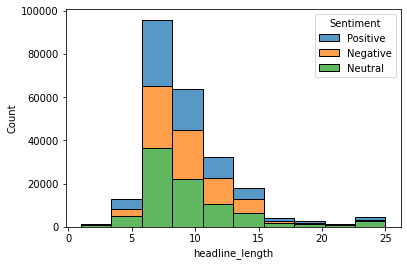

In [39]:
train['headline_length'] = train['Headlines'].apply(lambda x: min(len(x.split()), 25))
sns.histplot(data=train, x='headline_length', hue='Sentiment', multiple='stack', bins=10)

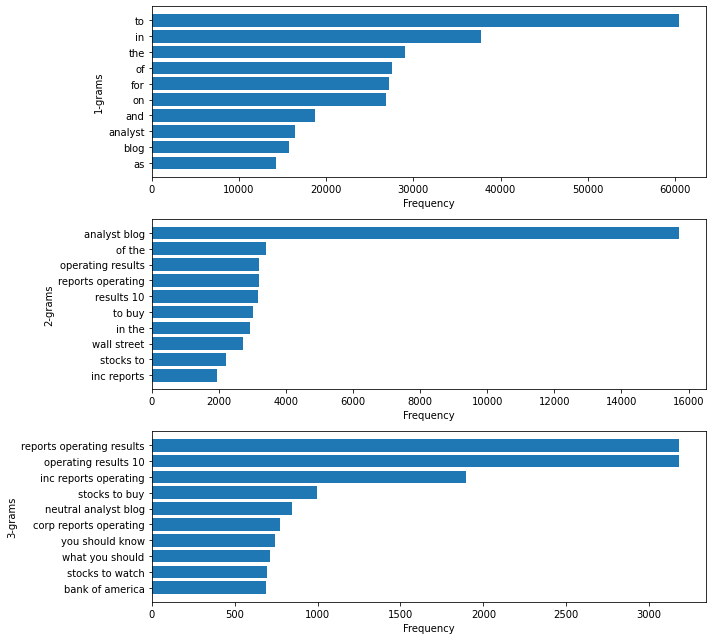

In [40]:
from sklearn.feature_extraction.text import CountVectorizer


def get_ngrams(corpus, ngrams=1, relative=False):
    """Get all n-grams from a corpus of text.
    
    Args:
        corpus: A list of strings representing the text documents.
        ngrams: The size of the n-grams to be extracted (default: 1).
        relative: If True, returns relative frequencies (default: False).
    
    Returns:
        A tuple containing two lists: n-gram words and their corresponding frequencies.
    """
    vec = CountVectorizer(ngram_range=(ngrams, ngrams)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    words, frequencies = zip(*words_freq)
    if relative:
        frequencies = frequencies / np.sum(frequencies)
    return words, frequencies


def plot_top_ngrams(ax, corpus, ngrams=1, top_k=10):
    """Plot the top k n-grams from a corpus of text."""
    words, frequencies = get_ngrams(corpus, ngrams=ngrams)
    words, frequencies = words[:top_k], frequencies[:top_k]
    ax.barh(words, frequencies)
    ax.invert_yaxis()
    ax.set_xlabel('Frequency')
    ax.set_ylabel(f'{ngrams}-grams')


fig, axes = plt.subplots(3, 1, figsize=(10, 9))
plot_top_ngrams(axes[0], train['Headlines'], ngrams=1)
plot_top_ngrams(axes[1], train['Headlines'], ngrams=2)
plot_top_ngrams(axes[2], train['Headlines'], ngrams=3)
plt.tight_layout()
plt.show()

The relative frequency of analyst blog is suspicious.

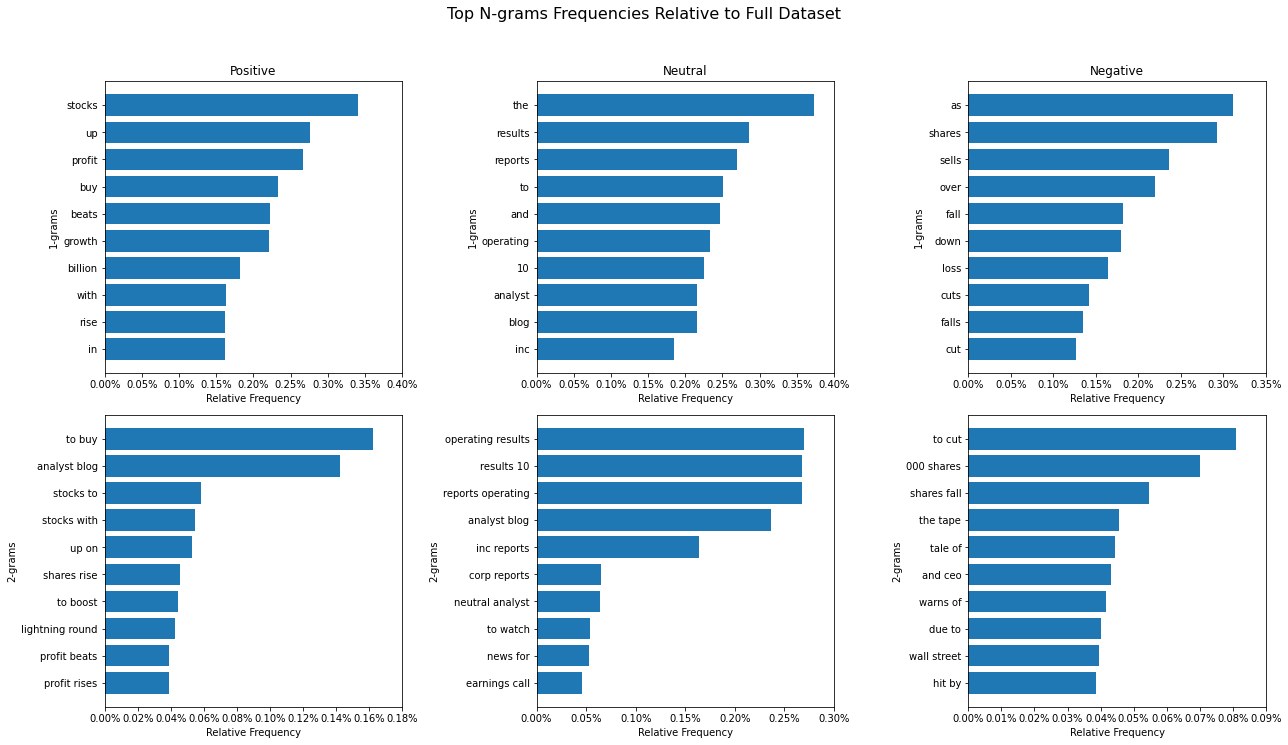

In [41]:
def plot_top_ngrams_relative(ax, corpus, total_counts, ngrams=1, top_k=10):
    """ Plot the top k n-grams relative to the total dataset for a given corpus.
    
    I.e. if 'bull' is 0.2% of the total dataset and 0.6% of the corpus, then the relative
    frequency of 'bull' is 0.6 - 0.2 = 0.4 %.
    
    Args:
        ax: A matplotlib axes object for plotting.
        corpus: A list of strings representing the text documents.
        total_counts: A dictionary containing the total counts of n-grams for all sentiments.
        ngrams: The size of the n-grams to be extracted (default: 1).
        top_k: The number of top n-grams to display (default: 10).
    """
    word_freq = get_ngrams(corpus, ngrams=ngrams, relative=True)
    relative_word_freq = [(w, f - total_counts[w]) for w, f in zip(*word_freq)]
    words_freq = sorted(relative_word_freq, key=lambda x: x[1], reverse=True)[:top_k]
    words, relative_frequencies = zip(*words_freq)

    ax.barh(words, relative_frequencies)
    ax.invert_yaxis()
    ax.set_xlabel('Relative Frequency')
    ax.set_ylabel(f'{ngrams}-grams')
    # Set x-axis to percentage
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels(['{:,.2%}'.format(x) for x in xticks])


total_1ngrams = get_ngrams(train['Headlines'], ngrams=1, relative=True)
total_1ngrams = dict(zip(*total_1ngrams))
total_2ngrams = get_ngrams(train['Headlines'], ngrams=2, relative=True)
total_2ngrams = dict(zip(*total_2ngrams))

unique_sentiments = ['Positive', 'Neutral', 'Negative']
num_sentiments = len(unique_sentiments)
fig, axes = plt.subplots(2, num_sentiments, figsize=(6 * num_sentiments, 10))

for col, sentiment in enumerate(unique_sentiments):
    headlines = train[train['Sentiment'] == sentiment]['Headlines']
    axes[0, col].set_title(sentiment)
    plot_top_ngrams_relative(axes[0, col], headlines, total_counts=total_1ngrams, ngrams=1)
    plot_top_ngrams_relative(axes[1, col], headlines, total_counts=total_2ngrams, ngrams=2)

fig.suptitle('Top N-grams Frequencies Relative to Full Dataset', fontsize=16, y=1.03)
plt.tight_layout()
plt.show()

### Some conclusions

- Duplicates should be removed in the pre-processing pipeline.
- The amount of `analyst blog` n-grams should be looked into. One of the datasets is probably full of 
analyst blogs instead of mainstream news headlines.
- The word `stocks` is suspiciously bullish. Do some manually testing of models with fictious 
headlines like *"Stocks crashes after the President announces new lockdown"*.